<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/spurce/DataExplorationVisuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls

Cloning into 'teambrainiac'...
remote: Enumerating objects: 761, done.
remote: Counting objects: 100% (761/761), done.
remote: Compressing objects: 100% (558/558), done.
remote: Total 761 (delta 473), reused 379 (delta 187), pack-reused 0
Receiving objects: 100% (761/761), 72.37 MiB | 32.40 MiB/s, done.
Resolving deltas: 100% (473/473), done.
/content/teambrainiac/source
access_data.py			  models
AccuracyMeasures.ipynb		  process.py
analysis.py			  SingleSubjectSVM.ipynb
cross_validation.py		  SubjectVisualization_Models_ZNORM.ipynb
data				  SVM_Group_Adolescent_Whole_brain.ipynb
DataExploration_SingleSubj.ipynb  SVM_Group_YA_Whole_brain.ipynb
DL				  TestMask.ipynb
Explore_data.ipynb		  train.py
Group_All_MASK_SVM.ipynb	  utils.py
helper				  VisualizationPlayground.ipynb
Images				  Visualize_Data.ipynb
__init__.py			  visualize.py


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


In [12]:
# Import libraries
!pip install boto3 nilearn nibabel
import nibabel as nib
from nilearn import plotting, image
from nilearn.image import threshold_img
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pickle
from utils import data_to_nib, load_mat, open_pickle, access_load_data, save_data, create_mask, labels_mask_binary, masking_data, masked_data_n_labels
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import numpy as np
import random
from nilearn.signal import clean
from utils import *
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
#open path dictionary file to get subject ids
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)
mask_data_filepath = data_path_dict['mask_data'][0]
mask_type_dict = access_load_data(mask_data_filepath, True)
np_array_mask = mask_type_dict['mask']
np_compatible_mask = np.ma.make_mask(np_array_mask).reshape(79*95*79,order='F')
ind = np.where(np_compatible_mask==True)
ind[0].shape

(237979,)

In [ ]:
#path_pd = pd.read_csv('/content/drive/My Drive/data/dataexploration/path_dict')


In [10]:

#affine_image = nib.load('/content/drive/My Drive/data/w3rtprun_01.nii')
#get image for header information
affine_image = access_load_data('w3rtprun_01.nii',False)
#get t1_image image for background
#this image is a template of a warped brain to normalized space
t1_image = access_load_data('single_subj_T1_resampled.nii',False)

In [11]:
viz_list = ['10047_09030','30017_09567']

In [ ]:
#Add cells for visuals(boxplots and get table of summary stats)

In [15]:
def create_bmaps(sub_id,data,indices_mask,image):
  """
    Function to compute beta maps using Lagrange values(alphas) from SVM.
      1. We want to create a zeroed vector to fill with the clf.dual_coef which correspond to the alphas
      2. We fill the vector with the alphas corresponding to the indices of the support vectors in clf.support_
      3. Reshape so we can find dot product
      4. Find dot prodoct between alphas and X_train data
      5. create a empty brain with dimensions 79*95*79
      6. reshape to a flattened vector
      7. fill the indices of the not masked voxels with the dot product
      8. reshape back to 3d brain
      9. create a nifti file of the brain for imaging
    Params:
      sub_id: subject id to get data from
      data: subject model and training/test data
      ind: indices of voxels to mask out
      image: template image to get header information for brain image
    Returns:
      bmap3: nifti file for imaging
  """
 
  clf = data[sub_id]['model'] # grab model
  X_train = data[sub_id]['X_train'] #grab training data
  y_train = data[sub_id]['y_train'] #grab labels

  alphas = np.zeros((84)) #create zero array
  alphas[clf.support_] = clf.dual_coef_ #fill indices with corresponding alphas
  alphas = alphas.reshape(1,-1) #reshape
  bmap = np.dot(alphas,X_train) #find dot product of X_train and alphas
  bmap2 = np.zeros((79,95,79)) #create empty 3-d brain
  bmap2 = bmap2.reshape(79*95*79) #flatten it to 1-d array
  bmap2[indices_mask] = bmap #fill indices of unmasked voxels w/the values created in bmap
  bmap2_3d = bmap2.reshape(79,95,79,order='F') #reshape back to a brain (3-d)
  bmap3 = nib.Nifti1Image(bmap2_3d,affine=image.affine,header=image.header) #save as nifti
  return bmap3
  

In [76]:
import matplotlib
matplotlib.use('Agg')
def plot_bmap(pickle_path,subject_type,norm_type,sub_id):
  """
    Function to create visualization for bmap. Displays image and saves it to output directory
    Params:
      pickle_path: path to subject model
      subject_type: str(Young Adult or Adolescent)
      norm_type: str(PSC,PSC_ZNORM,ZNORM,No Norm)
  """
  
  model_dict = open_pickle(pickle_path)
  bmap3 = create_bmaps(sub_id,model_dict,ind,affine_image)
  display = plotting.plot_stat_map(bmap3,bg_img=t1_image,
                                 colorbar=True, cmap='cold_hot', display_mode='z',cut_coords=(1,55,-3),black_bg=False,
                                 output_file=f'/content/drive/My Drive/data/dataexploration/{subject_type}_{norm_type}.png')
  display = plotting.plot_stat_map(bmap3,bg_img=t1_image, cut_coords=(1,55,-3),
                                 colorbar=True, cmap='hot', display_mode='z')
  #display.title(f'{norm_type} for {subject_type}', x=0.01, y=0.99, size=15, color='w', bgcolor='black')
 # display.output_file(f'/content/drive/My Drive/data/dataexploration/{subject_type}_{norm_type}.png')
  


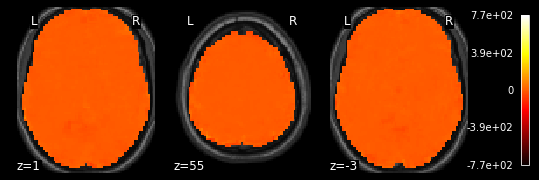

In [77]:
pickle_path = '/content/drive/My Drive/data/dataexploration/PSC_run_2_t_3_4_10047_09030.pkl'
sub_id = '10047_09030'
plot_bmap(pickle_path,'Adolescent','PSC',sub_id)


In [59]:

def get_threshold_image(bmap3):
  # Two types of strategies can be used from this threshold function
  # Type 1: strategy used will be based on scoreatpercentile
  threshold_percentile_img = threshold_img(bmap3, threshold='98%', copy=False)


  # Type 2: threshold strategy used will be based on image intensity
  # Here, threshold value should be within the limits i.e. less than max value.
  #threshold_value_img = threshold_img(bmap3, threshold=3.0, copy=False)
  return threshold_percentile_img

In [60]:



pickle_path = '/content/drive/My Drive/data/dataexploration/PSC_run_2_t_3_4_10047_09030.pkl'
sub_id = '10047_09030'
destination_path = f"{path}{sub_id}.pkl"
model_dict = open_pickle(pickle_path)
#print(model_dict[subj]['y_train'])
bmap3 = create_bmaps(sub_id,model_dict,ind,affine_image)
threshold_percentile_img = get_threshold_image(bmap3)
plotting.plot_stat_map(threshold_percentile_img, bg_img = t1_image, display_mode='y', cut_coords=5,
                      title=f'Threshold image with string percentile for subject {sub_id}', colorbar=True)

# Showing intensity threshold image
plotting.plot_stat_map(threshold_value_img, bg_img = t1_image, display_mode='y', cut_coords=5,
                      title=f'Threshold image with intensity value for subject {sub_id}', colorbar=True)

TypeError: ignored

In [ ]:
def plot_alphas(alphas,alpha_labels):
  fig, ax = plt.subplots(1,1,figsize=(15, 5))
  ax.plot(alphas, lw=3, label='scaled voxel tc')
  ax.plot(alphas_labels, lw=3, label='predictor tc')
  #ax.set_xlim(0, acq_num-1)
  ax.set_xlabel('time [volumes]', fontsize=20)
  ax.tick_params(labelsize=12)
  ax.set_title(sub_id)
  ax.legend()
  plt.show()

In [ ]:
def get_alphas(sub_id,data):
  clf = data[sub_id]['model']
  X_train = data[sub_id]['X_train']
  y_train = data[sub_id]['y_train']

  alphas = np.zeros((84))
  alphas[clf.support_] = clf.dual_coef_
  #alphas = alphas.reshape(1,-1)
  return alphas,y_train

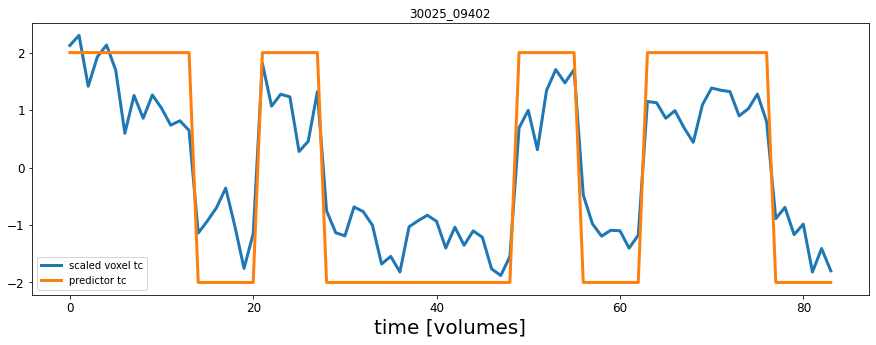

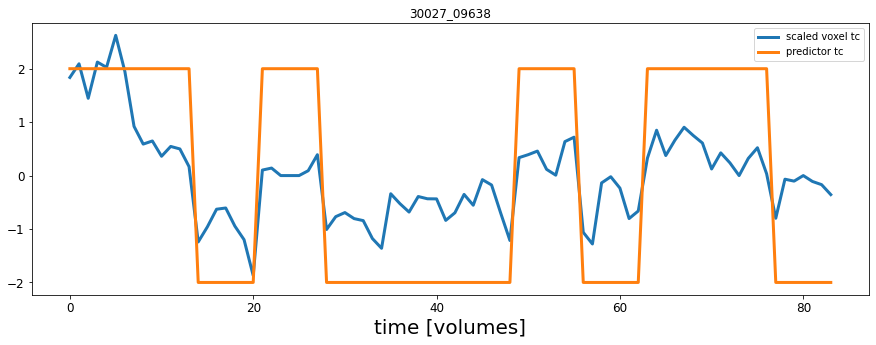

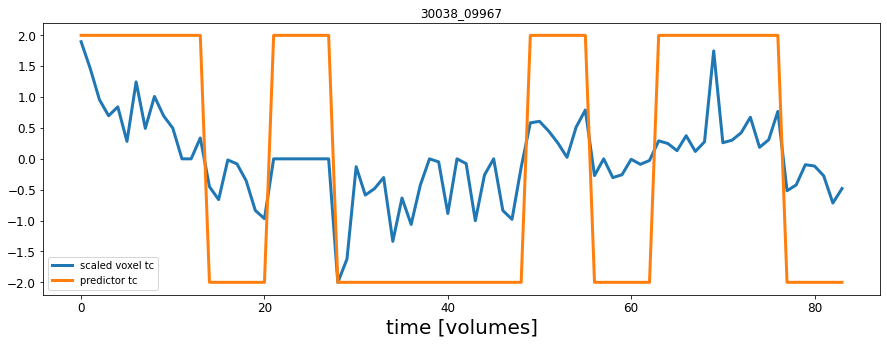

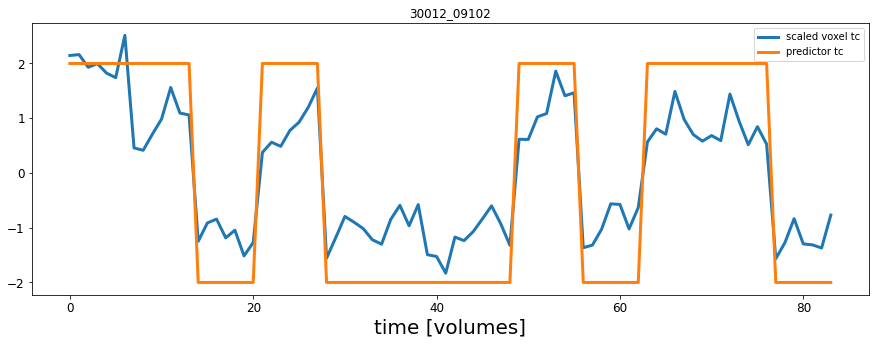

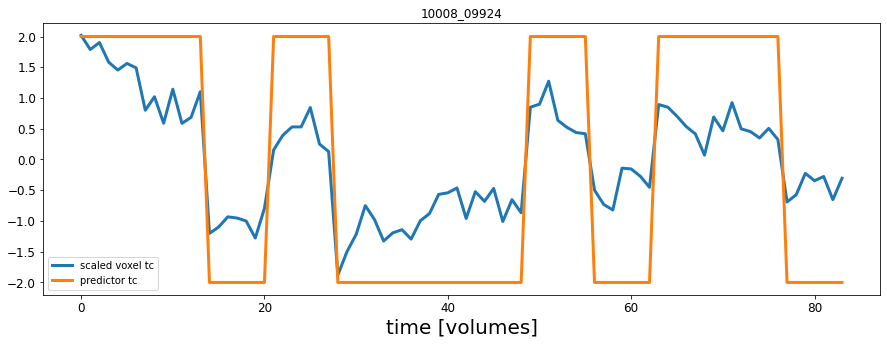

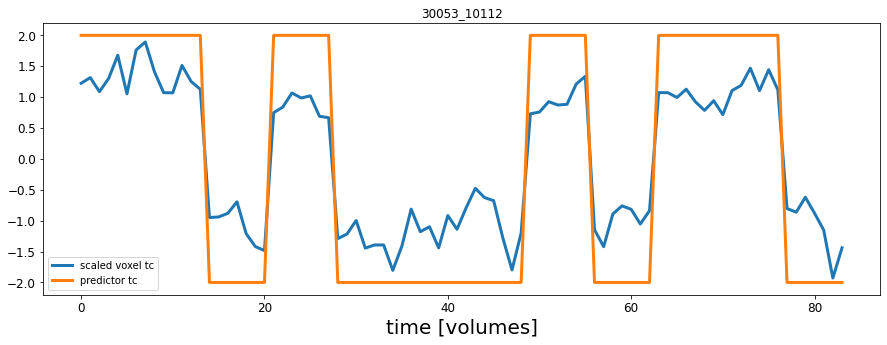

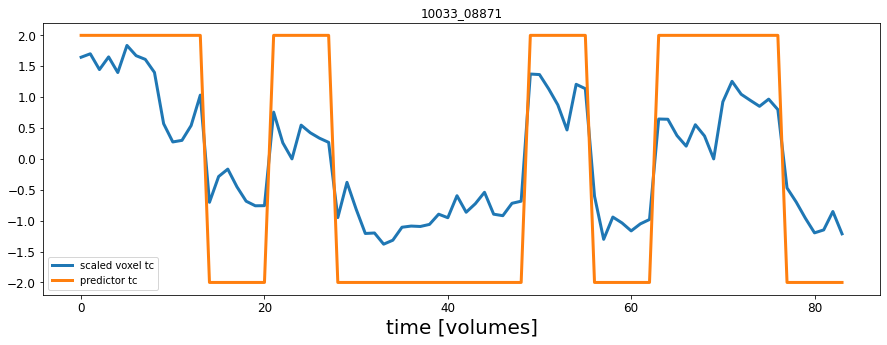

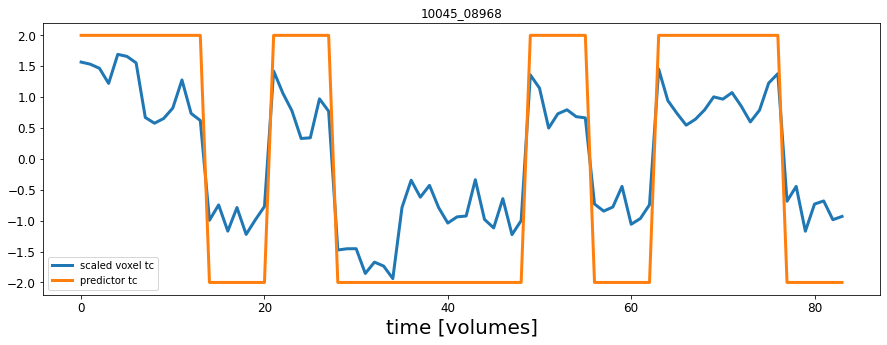

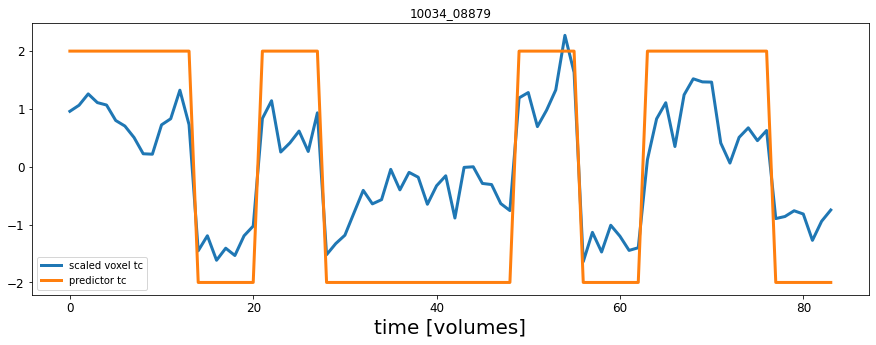

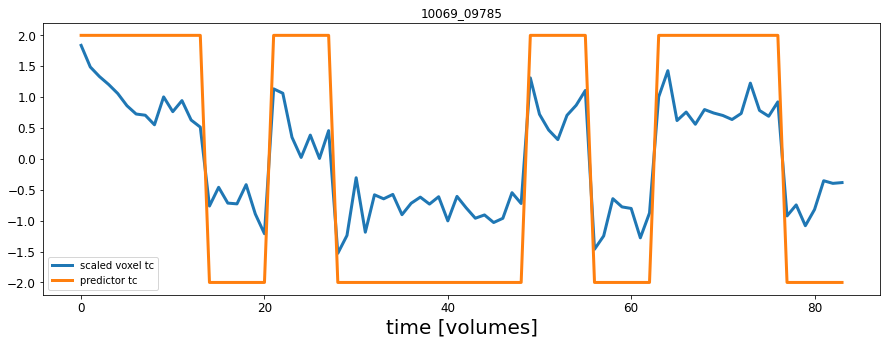

In [ ]:
for sub_id in viz_list:
  path = "/content/drive/My Drive/data/model_mPFC_sub_mask/one_run_model_znorm_"

  
  destination_path = f"{path}{sub_id}.pkl"
  model_dict = open_pickle(destination_path)
  alphas,y_train= get_alphas(sub_id,model_dict)
  alphas_labels = np.where(y_train==0,-2,2)
  plot_alphas(alphas,alphas_labels)

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



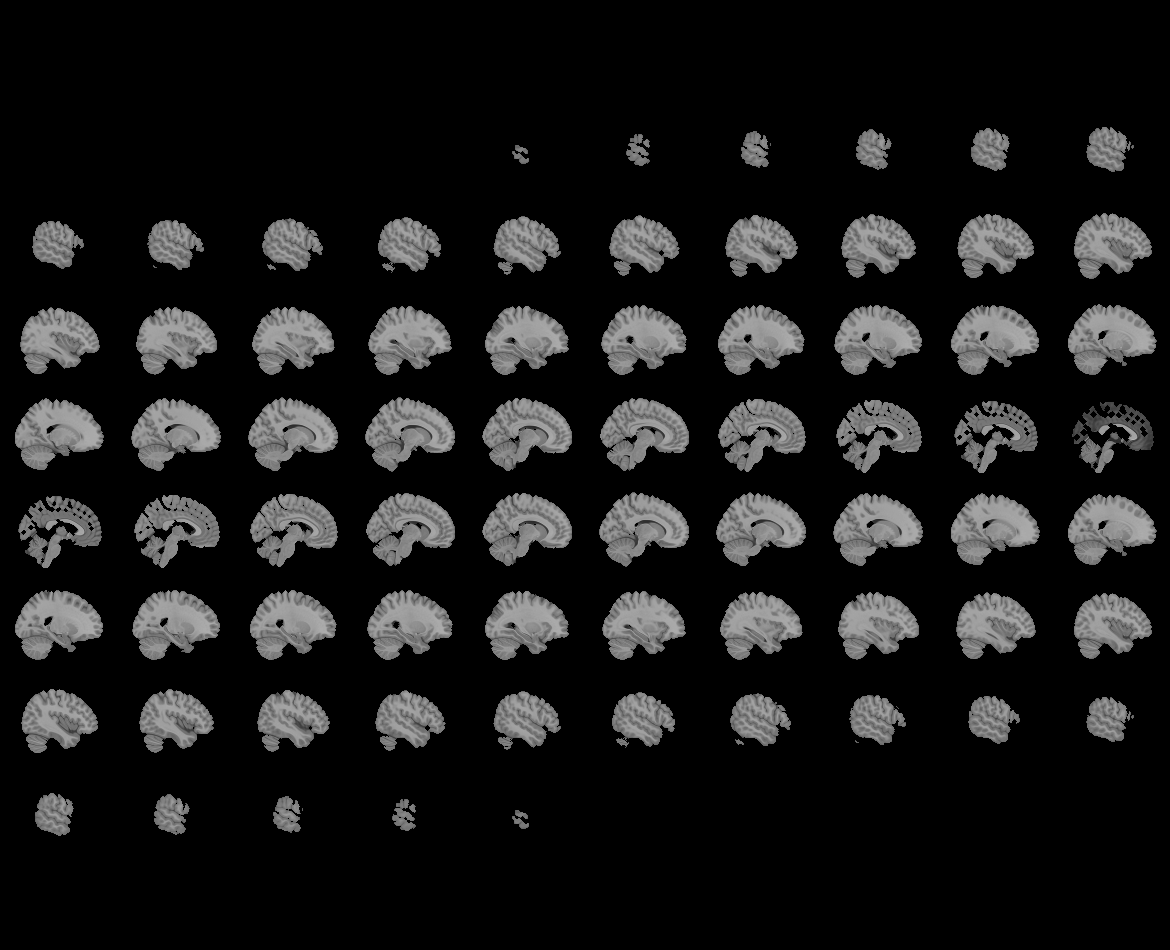
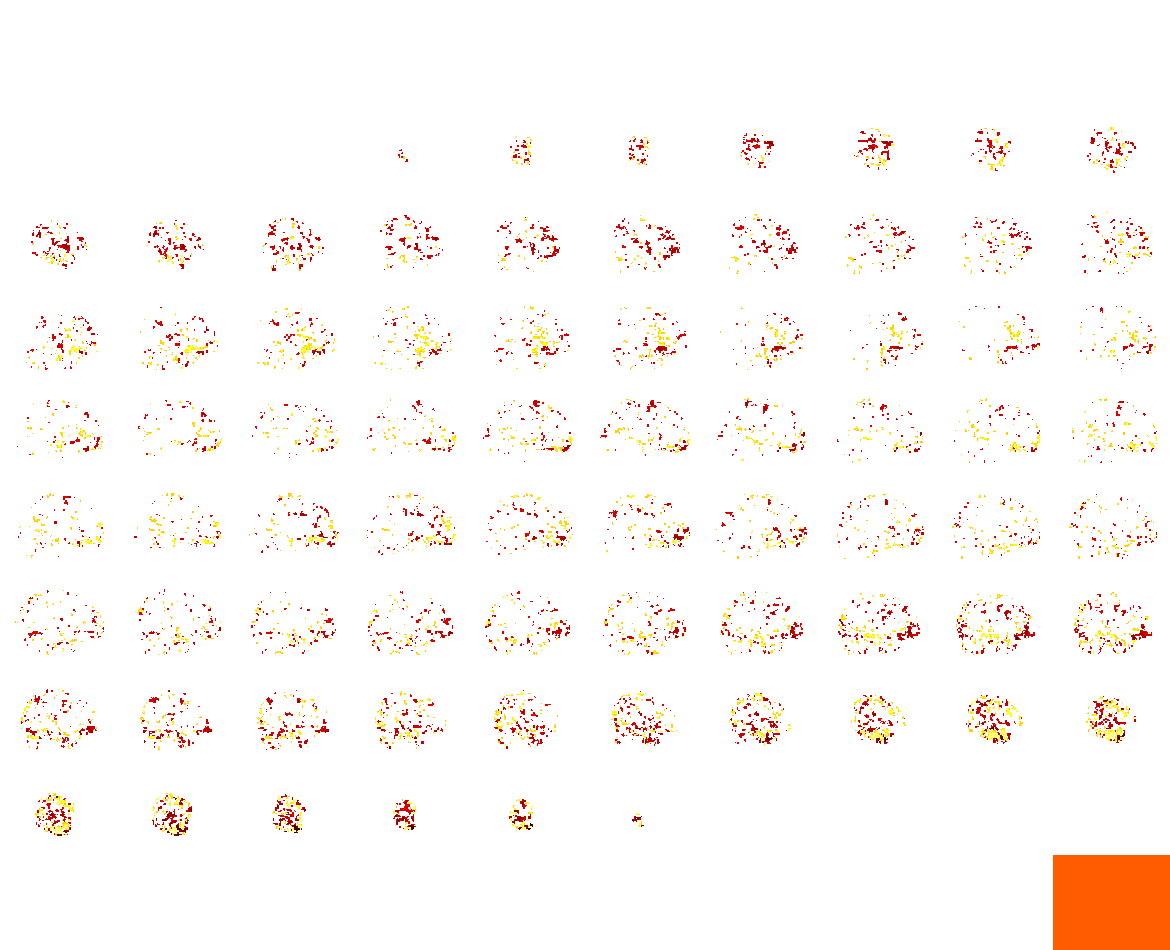

In [ ]:
###just for fun

from nilearn import plotting, datasets  
# #for sub_id in subject_ids:
#   path,file_beginning = ("/content/drive/My Drive/data/model_one_run_zcoreonly/",'sub_id_one_run_model_znorm')
#   destination_path = f"{path}{file_beginning}{sub_id}.pkl"
#   model_dict = open_pickle(destination_path)
#   bmap3 = create_bmaps(sub_id,model_dict,indices_mask,affine_image)  
#>>> img = datasets.fetch_localizer_button_task()['tmap']     
html_view = plotting.view_img(bmap3, bg=t1_image, threshold='90%', cmap = 'hot', cut_coords=[1, 55, -3],
                                    title="Motor contrast")
html_view  

In [ ]:
xlim


(3.9824478382690054, 10.798294812065512)

In [ ]:
Z.shape

(30, 30)